# Formate perovskites

Perovskites are an important class of inorganic materials, particularly for solar energy applications.
Usually, the perovskite structure contains an A cation, a B cation and an C anion in the ratio 1:1:3 (black, blue and red in the figure below, respectively, [see wikipeidia for more information](https://en.wikipedia.org/wiki/Perovskite_(structure)).

<img src="Perovskite.jpg">


Here we search for charge inverted perovskites, i.e. with an anion on the A site. This class of material is closely related to perovskites, and may represent another fruitful search space for new photovoltaic materials. 

In this example  we assume a simple [formate moelcule](https://en.wikipedia.org/wiki/Formate) as the C-site and uses [Goldschmidt ratio rules](https://en.wikipedia.org/wiki/Goldschmidt_tolerance_factor) as part of the screening.
These rules allow us to estimate whether or not a perovskite structure is likely to form based on data about ionic size alone. The tolerance factor is defined as a ratio of the radii of the A, B and C species


\begin{equation*}
t = \frac{r^A + r^C}{\sqrt{2}(r^B + r^C)} ,
\end{equation*}

Values of t > 1 imply a relatively large A site favoring a hexagonal structure, 0.9 < t < 1 predicts a cubic structure, and 0.7 < t < 0.9 means that the A site is small, preferring an orthorhombic structure. For t < 0.7, other (non-perovskite) structures are predicted.

We also apply the standard charge neutrality and electronegativity tests as described [in the docs](https://smact.readthedocs.io/en/latest/examples.html#neutral-combinations).


We outline 2 approaches for achieveing the same result:

1. The methodology is written out explicitly for transparency, including accessing the `smact` data directory directly and storing element and species information as simple lists of strings, ints and floats.

2. Fewer lines of code are used, making use of inbuilt `smact` functions. Element and species information is stored directly as Element and Species objects.

In [1]:
### IMPORTS ###
get_ipython().magic("matplotlib inline")  # plots appear in the notebook
import copy
import csv
import os
from itertools import product

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import smact
import smact.lattice as lattice
import smact.screening as screening
from smact import Element, Species, data_directory

First we define the positions of the 3 sites in the perovskite structure and specify the allowed oxidation states at each site. Note that the A site is defined as an anion (i.e. with a -1 oxidation state).

In [2]:
site_A = lattice.Site([0, 0, 0], [-1])
site_B = lattice.Site([0.5, 0.5, 0.5], [+5, +4])
site_C = lattice.Site([0.5, 0.5, 0.5], [-2, -1])
perovskite = lattice.Lattice([site_A, site_B, site_C], space_group=221)

___
### Approach 1

We now search through the elements of interest (Li-Fr) and find those that are allowed on each site. In this example, we use the F- anion with an increased Shannon radius to simulate the formate anion. We access the Shannon radii data directly from the smact data directory and are interested in the octahedral (6_n) Shannon radius. 

In [3]:
search = smact.ordered_elements(3, 87)  # Li - Fr

A_list = []  # will be populated with anions
B_list = []  # will be populated with cations
C_list = [["F", -1, 4.47]]  # is always the "formate anion"
for element in search:
    with open(os.path.join(data_directory, "shannon_radii.csv")) as f:
        reader = csv.reader(f)
        r_shannon = False
        for row in reader:
            if (
                row[2] == "6_n"
                and row[0] == element
                and int(row[1]) in site_A.oxidation_states
            ):
                A_list.append([row[0], int(row[1]), float(row[4])])
            if (
                row[2] == "6_n"
                and row[0] == element
                and int(row[1]) in site_B.oxidation_states
            ):
                B_list.append([row[0], int(row[1]), float(row[4])])

*NB: We access the data directly from the data directory file here for transparency. However, reading the file multiple times would slow down the code if we were looping over many (perhaps millions to billions) of compositions. As such, reading all the data in once into a dictionary, then accessing that dictionary from within a loop, could be preferable, e.g.:*
``` python
for element in search:
    ...
    r_shannon = shannon_radii[element][coordination]
    ...
```

We go through and apply the electronegativity order test (pauling_test) to each combo. Then, we use Goldschmidt tolernace factor to group into crystal structure types.

In [4]:
# We define the different categories of list we will populate
charge_balanced = []
goldschmidt_cubic = []
goldschmidt_ortho = []
a_too_large = []
A_B_similar = []
pauling_perov = []
anion_stats = []

# We recursively search all ABC combinations using nested for loops
for C in C_list:
    anion_hex = 0
    anion_cub = 0
    anion_ort = 0
    for B in B_list:
        for A in A_list:
            # We check that we have 3 different elements
            if B[0] != A[0]:
                # Check for charge neutrality
                if int(A[1]) + int(B[1]) + 3 * int(C[1]) == 0:
                    charge_balanced.append([A[0], B[0], C[0]])
                    # We apply the pauling electronegativity test
                    paul_a = smact.Element(A[0]).pauling_eneg
                    paul_b = smact.Element(B[0]).pauling_eneg
                    paul_c = smact.Element(C[0]).pauling_eneg
                    electroneg_makes_sense = screening.pauling_test(
                        [A[1], B[1], C[1]], [paul_a, paul_b, paul_c]
                    )
                    if electroneg_makes_sense:
                        pauling_perov.append([A[0], B[0], C[0]])
                        # We calculate the Goldschmidt tolerance factor
                        tol = (float(A[2]) + C[2]) / (np.sqrt(2) * (float(B[2]) + C[2]))
                        if tol > 1.0:
                            a_too_large.append([A[0], B[0], C[0]])
                            anion_hex = anion_hex + 1
                        if tol > 0.9 and tol <= 1.0:
                            goldschmidt_cubic.append([A[0], B[0], C[0]])
                            anion_cub = anion_cub + 1
                        if tol >= 0.71 and tol < 0.9:
                            goldschmidt_ortho.append([A[0], B[0], C[0]])
                            anion_ort = anion_ort + 1
                        if tol < 0.71:
                            A_B_similar.append([A[0], B[0], C[0]])
anion_stats.append([anion_hex, anion_cub, anion_ort])

[[1, 40, 91]]
Number of possible charge neutral perovskites from Li to Fr = 132
Number of Pauling senseibe perovskites from Li to Fr = 132
Number of possible cubic perovskites from Li to Fr = 40
Number of possible ortho perovskites from Li to Fr = 91
Number of possible hexagonal perovskites from Li to Fr = 1
Number of possible non-perovskites from Li to Fr = 0
----------------------------------------------------------------
Structures identified with cubic tolerance factor 0.9 < t < 1.0 
----------------------------------------------------------------
Cl C (HCOO)3
Br C (HCOO)3
Cl Si (HCOO)3
Br Si (HCOO)3
I Si (HCOO)3
Cl S (HCOO)3
Br S (HCOO)3
I S (HCOO)3
I Ti (HCOO)3
Br V (HCOO)3
I V (HCOO)3
Br Cr (HCOO)3
I Cr (HCOO)3
Br Mn (HCOO)3
I Mn (HCOO)3
I Fe (HCOO)3
Br Co (HCOO)3
I Co (HCOO)3
Br Ni (HCOO)3
I Ni (HCOO)3
Br Ge (HCOO)3
I Ge (HCOO)3
Br Se (HCOO)3
I Se (HCOO)3
I Zr (HCOO)3
I Nb (HCOO)3
I Mo (HCOO)3
I Tc (HCOO)3
I Ru (HCOO)3
I Rh (HCOO)3
I Pd (HCOO)3
I Sn (HCOO)3
I Tb (HCOO)3
I Hf (H

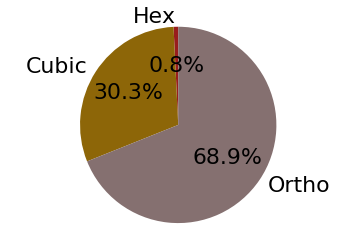

In [5]:
print(anion_stats)
colours = ["#991D1D", "#8D6608", "#857070"]
matplotlib.rcParams.update({"font.size": 22})
plt.pie(
    anion_stats[0],
    labels=["Hex", "Cubic", "Ortho"],
    startangle=90,
    autopct="%1.1f%%",
    colors=colours,
)
plt.axis("equal")
plt.savefig("Form-perovskites.png")

print(
    "Number of possible charge neutral perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(charge_balanced),
)
print(
    "Number of Pauling sensible perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(pauling_perov),
)
print(
    "Number of possible cubic perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(goldschmidt_cubic),
)
print(
    "Number of possible ortho perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(goldschmidt_ortho),
)
print(
    "Number of possible hexagonal perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(a_too_large),
)
print(
    "Number of possible non-perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(A_B_similar),
)


# print goldschmidt_cubic
print("----------------------------------------------------------------")
print("Structures identified with cubic tolerance factor 0.9 < t < 1.0 ")
print("----------------------------------------------------------------")
for structure in goldschmidt_cubic:
    print(structure[0], structure[1], "(HCOO)3")

___
### Approach 2

In [6]:
# Get list of Element objects
search = [el for el in smact.ordered_elements(3, 87) if Element(el).oxidation_states]

# Covert to list of Species objects
all_species = []
for el in search:
    for oxi_state in Element(el).oxidation_states:
        all_species.append(Species(el, oxi_state, "6_n"))

# Define lists of interest
A_list = [sp for sp in all_species if (sp.oxidation == -1) and (sp.ionic_radius)]
B_list = [sp for sp in all_species if (4 <= sp.oxidation <= 5) and (sp.ionic_radius)]
C_list = [Species("F", -1, 4.47)]

In [7]:
# We define the different categories of list we will populate
charge_balanced = []
goldschmidt_cubic = []
goldschmidt_ortho = []
a_too_large = []
A_B_similar = []
pauling_perov = []
anion_stats = []

for combo in product(A_list, B_list, C_list):
    A, B, C = combo[0], combo[1], combo[2]
    # Check for charge neutrality in 1:1:3 ratio
    if (1, 1, 3) in screening.neutral_ratios([A.oxidation, B.oxidation, C.oxidation])[
        1
    ]:
        charge_balanced.append(combo)
        # Check for pauling test
        if screening.pauling_test(
            [A.oxidation, B.oxidation, C.oxidation],
            [A.pauling_eneg, B.pauling_eneg, C.pauling_eneg],
        ):
            pauling_perov.append(combo)
            # Calculate tolerance factor
            tol = (float(A.ionic_radius) + 4.47) / (
                np.sqrt(2) * (float(B.ionic_radius) + 4.47)
            )
            if tol > 1.0:
                a_too_large.append(combo)
            if tol > 0.9 and tol <= 1.0:
                goldschmidt_cubic.append([combo])
            if tol >= 0.71 and tol < 0.9:
                goldschmidt_ortho.append(combo)
            if tol < 0.71:
                A_B_similar.append(combo)

In [9]:
print(
    "Number of possible charge neutral perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(charge_balanced),
)
print(
    "Number of Pauling sensible perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(pauling_perov),
)
print(
    "Number of possible cubic perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(goldschmidt_cubic),
)
print(
    "Number of possible ortho perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(goldschmidt_ortho),
)
print(
    "Number of possible hexagonal perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(a_too_large),
)
print(
    "Number of possible non-perovskites from",
    search[0],
    "to",
    search[len(search) - 1],
    "=",
    len(A_B_similar),
)


# print goldschmidt_cubic
print("----------------------------------------------------------------")
print("Structures identified with cubic tolerance factor 0.9 < t < 1.0 ")
print("----------------------------------------------------------------")
for structure in goldschmidt_cubic:
    print(structure[0][0].symbol, structure[0][1].symbol, "(HCOO)3")

Number of possible charge neutral perovskites from Li to Fr = 132
Number of Pauling senseibe perovskites from Li to Fr = 132
Number of possible cubic perovskites from Li to Fr = 40
Number of possible ortho perovskites from Li to Fr = 91
Number of possible hexagonal perovskites from Li to Fr = 1
Number of possible non-perovskites from Li to Fr = 0
----------------------------------------------------------------
Structures identified with cubic tolerance factor 0.9 < t < 1.0 
----------------------------------------------------------------
Cl C (HCOO)3
Cl Si (HCOO)3
Cl S (HCOO)3
Br C (HCOO)3
Br Si (HCOO)3
Br S (HCOO)3
Br V (HCOO)3
Br Cr (HCOO)3
Br Mn (HCOO)3
Br Co (HCOO)3
Br Ni (HCOO)3
Br Ge (HCOO)3
Br Se (HCOO)3
I Si (HCOO)3
I S (HCOO)3
I Ti (HCOO)3
I V (HCOO)3
I Cr (HCOO)3
I Mn (HCOO)3
I Fe (HCOO)3
I Co (HCOO)3
I Ni (HCOO)3
I Ge (HCOO)3
I Se (HCOO)3
I Zr (HCOO)3
I Nb (HCOO)3
I Mo (HCOO)3
I Tc (HCOO)3
I Ru (HCOO)3
I Rh (HCOO)3
I Pd (HCOO)3
I Sn (HCOO)3
I Tb (HCOO)3
I Hf (HCOO)3
I Ta (HC